### Project 3: Plausible Utopia 

### Classification Modeling on Subreddits to Classify Futurists vs. Scientists

### Notebook 2 of 3: Modeling

#### Libary imports

In [109]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

     
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

import warnings; warnings.simplefilter('ignore')
##this will hide deprecation/future warnings

from IPython.display import Markdown, display
pd.set_option('display.max_row', 200) # Set ipython's max row display
pd.set_option('display.max_columns', 85) # Set iPython's max column count
pd.set_option('display.max_colwidth', 1_000) # Set iPython's max column width

# pseudo-markdown in code cells
def printmd(string):
    display(Markdown(string))
# ref: https://discuss.analyticsvidhya.com/t/how-to-make-a-text-bold-within-print-statement-in-ipython-notebook/14552/2

In [110]:
# Read in the cleaned data
subred = pd.read_csv('../data/cleaned_data/cleaned_df_1.csv', index_col = 'id')
subred.shape

(1800, 7)

#### Set the features

In [111]:
# Set feature matrix and target variable

X = subred['title']
y = subred['subreddit']

read the following from ISLR:

5.2 - The Bootstrap. (You'll want to know the bootstrap well as it will be embedded in methods we'll discuss next week.)
Chapter 8 - Tree Based Methods. (We'll learn about classification and regression trees, random forests, bagging and boosting next week.)
9.1-9.5 (Support Vector Machines and related methods)

### Identify an optimal model with a pipeline and GridSearch

### Train-test split

 **Ref: 5.05 lesson**
 
 Features can be completely different in train/test
 
**IMPORTANT** Instead of splitting we can use entire dataset combined with cross-validation
 
 Depending on how big dataset is, significant words in train set will probably appear in test set

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    stratify = y,
                                                    random_state = 42)

display(X_train.shape)
display(y_train.shape)

display(X_test.shape)
display(y_test.shape)

(1206,)

(1206,)

(594,)

(594,)

### Baseline accuracy

**51.7% is the baseline accuracy percentage we compare with the model's accuracy.**

**If the model does better than the baseline, then it is better than null model (predicting the majority / plurality class).**

In [113]:
display(y.value_counts(normalize=True))

display(y_train.value_counts(normalize=True))

y_test.value_counts(normalize=True)

science       0.517222
futurology    0.482778
Name: subreddit, dtype: float64

science       0.517413
futurology    0.482587
Name: subreddit, dtype: float64

science       0.516835
futurology    0.483165
Name: subreddit, dtype: float64

## Cutoff point 

### Build pipelines

### Pipeline 1

**CountVectorizer (transformer)**:



**Multinomial Naive Bayes (estimator)**:

* Fast modeling algorithm
* Variables are positive integers
* Assumes all variables are independent (which is not realistic in NLP, but this assumption is accepted anyway)

In [44]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())    # Naive Bayes
])


# Search over the following values of hyperparameters:
# Maximum number of features fit
# Minimum number of documents needed to include token
# Maximum number of documents needed to include token
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_cvec_nb_params = {
    'cvec__max_features': [1_000, 2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.98, .99],
    'cvec__ngram_range': [(1,1), (1,2)]
}

# Instantiate GridSearchCV.

gs_cvec_nb = GridSearchCV(pipe_cvec_nb, # what object are we optimizing?
                  param_grid = pipe_cvec_nb_params, # what parameters values are we searching?
                  cv=5)      # 5-fold cross-validation.

In [64]:
# Fit GridSearch to data.
gs_cvec_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.98, 0.99],
                         'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

#### Evaluate the model

In [46]:
printmd('**Grid searched:**')
display(gs_cvec_nb.param_grid)
printmd(f'**Best score**: {round(gs_cvec_nb.best_score_, 4)}')
printmd('**Best estimator / parameters:**')
display(gs_cvec_nb.best_estimator_)
display(gs_cvec_nb.best_params_)

pd.DataFrame(gs_cvec_nb.cv_results_).sort_values('rank_test_score').head()

**Grid searched:**

{'cvec__max_features': [1000, 2000, 3000, 4000, 5000],
 'cvec__min_df': [1, 2],
 'cvec__max_df': [0.98, 0.99],
 'cvec__ngram_range': [(1, 1), (1, 2)]}

**Best score**: 0.825

**Best estimator / parameters:**

Pipeline(steps=[('cvec', CountVectorizer(max_df=0.98, max_features=5000)),
                ('nb', MultinomialNB())])

{'cvec__max_df': 0.98,
 'cvec__max_features': 5000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
36,0.055658,0.005598,0.010372,0.000799,0.99,5000,1,"(1, 1)","{'cvec__max_df': 0.99, 'cvec__max_features': 5000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}",0.826446,0.800830,0.842324,0.821577,0.834025,0.825040,0.013997,1
16,0.059448,0.005179,0.013956,0.002828,0.98,5000,1,"(1, 1)","{'cvec__max_df': 0.98, 'cvec__max_features': 5000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}",0.826446,0.800830,0.842324,0.821577,0.834025,0.825040,0.013997,1
37,0.153983,0.009230,0.022540,0.001017,0.99,5000,1,"(1, 2)","{'cvec__max_df': 0.99, 'cvec__max_features': 5000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2)}",0.842975,0.804979,0.834025,0.813278,0.825726,0.824197,0.013712,3
17,0.154194,0.020380,0.019754,0.003175,0.98,5000,1,"(1, 2)","{'cvec__max_df': 0.98, 'cvec__max_features': 5000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2)}",0.842975,0.804979,0.834025,0.813278,0.825726,0.824197,0.013712,3
32,0.033315,0.003920,0.006380,0.000485,0.99,4000,1,"(1, 1)","{'cvec__max_df': 0.99, 'cvec__max_features': 4000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}",0.830579,0.800830,0.825726,0.809129,0.838174,0.820887,0.013833,5


#### Predictions

credit: NLP II: `CountVectorizer`, `TfidfVectorizer`, and Modeling lesson. _Authors: Dave Yerrington (SF), Justin Pounders (ATL), Riley Dallas (ATX), Matt Brems (DC), Noelle Brown (DEN)_

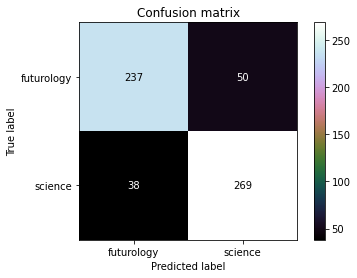

In [47]:
# Get predictions
preds = gs_cvec_nb.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix

plot_confusion_matrix(gs_cvec_nb, X_test, y_test, cmap='cubehelix', values_format='d');
plt.title('Confusion matrix')

printmd('credit: NLP II: `CountVectorizer`, `TfidfVectorizer`, and Modeling lesson. _Authors: Dave Yerrington (SF), Justin Pounders (ATL), Riley Dallas (ATX), Matt Brems (DC), Noelle Brown (DEN)_')

In [48]:
# Calculate the accuracy

acc = (tp + tn) / (tp + fp + tn + fn)
print('Accuracy:', acc)

# Calculate the misclassification rate

misclass = (fp + fn) / (tp + fp + tn + fn)
print('Misclassification:', misclass)

# Calculate the sensitivity

sens = tp / (tp + fn)
print('Sensitivity:', sens)

# Calculate the precision

prec = tp / (tp + fp)
print('Precision:', prec)

# Calculate the specificity

spec = tn / (tn + fp)
print('Specificity:', spec)

def metrics(y_test, y_predict, pred_proba):
    print('Accuracy score %s ' % accuracy_score(y_test, y_predict), '\n')
    print('----------------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(y_test, y_predict), 
                            index=['Not Actual Disaster', 'Actual Disaster'], 
                            columns=['Predicted Not Actual Disaster', 'Predicted Disaster']), '\n')
    print('-----------------------------------------------------------------')
    print(classification_report(y_test, y_predict))
    print('-----------------------------------------------------------------')
    print('ROC_AUC SCORE %s ' %roc_auc_score(y_test, pred_proba))
    
# credit: Heather Robinson :-)

Accuracy: 0.8518518518518519
Misclassification: 0.14814814814814814
Sensitivity: 0.8762214983713354
Precision: 0.8432601880877743
Specificity: 0.8257839721254355


#### Update the scoreboard or not? These are artificially high scores

| Model # |     Model metrics     |  Score | Before preprocessing shape | train_test_split  | Value |   Pipeline  |        pipe_cvec_nb       | Pipe hyperparameters |                         Value set                         | GridsearchCV parameters | Value | GridsearchCV BEST parameters | Value  |
|:-------:|:---------------------:|:------:|:--------------------------:|:-----------------:|:-----:|:-----------:|:-------------------------:|:--------------------:|:---------------------------------------------------------:|:-----------------------:|:-----:|:----------------------------:|--------|
|    1    |       Best score      | 0.8389 |          (1800, 7)         |     test_size     |  0.33 | Transformer | 'cvec', CountVectorizer() |     max_features     | 'cvec__max_features': [1_000, 2_000, 3_000, 4_000, 5_000] | k-fold cross-validation |   5   | cvec__max_df                 | 0.98   |
|    1    | |  |                            |      stratify     |   y   |  Estimator  |   'nb', MultinomialNB()   |        min_df        |                   'cvec__min_df': [1, 2]                  |                         |       | cvec__max_features           | 4000   |
|    1    |   |  |                            |    random_state   |   42  |             |                           |        max_df        |                 'cvec__max_df': [.98, .99]                |                         |       | cvec__min_df                 | 1      |
|    1    |                       |        |                            |                   |       |             |                           |      ngram_range     |             'cvec__ngram_range': [(1,1), (1,2)            |                         |       | cvec__ngram_range            | (1, 2) |
|    1    |                       |        |                            |                   |       |             |                           |                      |                                                           |                         |       |                              |        |

### Pipeline 1 Part 2

**CountVectorizer (transformer)**:



**Multinomial Naive Bayes (estimator)**:

* Fast modeling algorithm
* Variables are positive integers
* Assumes all variables are independent (which is not realistic in NLP, but this assumption is accepted anyway)

In [114]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())    # Naive Bayes
])


# Search over the following values of hyperparameters:
# Maximum number of features fit
# Minimum number of documents needed to include token
# Maximum number of documents needed to include token
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_cvec_nb_params = {
    'cvec__max_features': [4_000, 6_000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.05, .1, .25, .4],
    'cvec__ngram_range': [(1,1)]
}

# Instantiate GridSearchCV.

gs_cvec_nb = GridSearchCV(pipe_cvec_nb, # what object are we optimizing?
                  param_grid = pipe_cvec_nb_params, # what parameters values are we searching?
                  cv=5)      # 5-fold cross-validation.

In [115]:
# Fit GridSearch to data.
gs_cvec_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.05, 0.1, 0.25, 0.4],
                         'cvec__max_features': [6000], 'cvec__min_df': [1],
                         'cvec__ngram_range': [(1, 1)]})

**Evaluate the model**

In [116]:
printmd('**Grid searched:**')
display(gs_cvec_nb.param_grid)
printmd(f'**Best score**: {round(gs_cvec_nb.best_score_, 4)}')
printmd('**Best estimator / parameters:**')
display(gs_cvec_nb.best_estimator_)
display(gs_cvec_nb.best_params_)

pd.DataFrame(gs_cvec_nb.cv_results_).sort_values('rank_test_score').head()

**Grid searched:**

{'cvec__max_features': [6000],
 'cvec__min_df': [1],
 'cvec__max_df': [0.05, 0.1, 0.25, 0.4],
 'cvec__ngram_range': [(1, 1)]}

**Best score**: 0.8342

**Best estimator / parameters:**

Pipeline(steps=[('cvec', CountVectorizer(max_df=0.4, max_features=6000)),
                ('nb', MultinomialNB())])

{'cvec__max_df': 0.4,
 'cvec__max_features': 6000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_df,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.026922,0.005012,0.004993,0.000632,0.4,6000,1,"(1, 1)","{'cvec__max_df': 0.4, 'cvec__max_features': 6000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}",0.830579,0.813278,0.854772,0.829876,0.842324,0.834165,0.013847,1
2,0.024341,0.001346,0.005186,0.000399,0.25,6000,1,"(1, 1)","{'cvec__max_df': 0.25, 'cvec__max_features': 6000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}",0.826446,0.809129,0.846473,0.825726,0.834025,0.828360,0.012171,2
1,0.025531,0.002240,0.004388,0.000489,0.1,6000,1,"(1, 1)","{'cvec__max_df': 0.1, 'cvec__max_features': 6000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}",0.830579,0.788382,0.850622,0.821577,0.825726,0.823377,0.020138,3
0,0.026728,0.004161,0.004994,0.000641,0.05,6000,1,"(1, 1)","{'cvec__max_df': 0.05, 'cvec__max_features': 6000, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1)}",0.805785,0.788382,0.846473,0.813278,0.821577,0.815099,0.019132,4


### Pipeline 2

**CountVectorizer (transformer)**:

**TF-IDF (transformer)**:



**Logistic Regression (estimator)**:

* Relatively interpretable results

In [81]:
# Let's set up another pipeline
# 1. CountVectorizer (transformer)
# 2. TfidfVectorizer (transformer)
# 3. LogisticRegression (estimator)

pipe_log_reg_with_cvec_tfidf = Pipeline([
    ('cvec', CountVectorizer(lowercase = False)),
#     ('tvec', TfidfVectorizer(lowercase = False)),
    ('log_reg', LogisticRegression())
])

# Search over the following values of hyperparameters:
# Maximum number of features fit
# Minimum number of documents needed to include token
# Maximum number of documents needed to include token
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_log_reg_with_cvec_tfidf_params = {
    'cvec__max_features': [1_000, 3_000, 5_000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [.98, .99],
    'cvec__ngram_range': [(1,1), (2,1)],
    'cvec__stop_words': [None, 'english'],
#     'tvec__max_features': [3_000, 5_000],
    'tvec__stop_words': [None, 'english'],
#     'tvec__ngram_range': [(1,1), (1,2)],
    'log_reg__C': [1, 0.5],
    'log_reg__penalty': ['l1', 'l2']
}

# Instantiate GridSearchCV.

gs_log_reg_with_cvec_tfidf = GridSearchCV(pipe_log_reg_with_cvec_tfidf, # what object are we optimizing?
                  param_grid = pipe_log_reg_with_cvec_tfidf_params, # what parameters values are we searching?
                  cv=5)      # 5-fold cross-validation.

In [82]:
# Fit GridSearch to data.
pipe_log_reg_with_cvec_tfidf.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer(lowercase=False)),
                ('log_reg', LogisticRegression())])

In [83]:
printmd('**Grid searched:**')
display(gs_log_reg_with_cvec_tfidf.param_grid)
printmd(f'**Best score**: {round(gs_log_reg_with_cvec_tfidf.best_score_, 4)}')
printmd('**Best estimator / parameters:**')
display(gs_log_reg_with_cvec_tfidf.best_estimator_)
display(gs_log_reg_with_cvec_tfidf.best_params_)

pd.DataFrame(gs_log_reg_with_cvec_tfidf.cv_results_).sort_values('rank_test_score').head()

**Grid searched:**

{'cvec__max_features': [1000, 3000, 5000],
 'cvec__min_df': [1, 2],
 'cvec__max_df': [0.98, 0.99],
 'cvec__ngram_range': [(1, 1), (2, 1)],
 'cvec__stop_words': [None, 'english'],
 'tvec__stop_words': [None, 'english'],
 'log_reg__C': [1, 0.5],
 'log_reg__penalty': ['l1', 'l2']}

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

### Pipeline 3

Tout un ensemble

https://scikit-learn.org/stable/modules/ensemble.html

**CountVectorizer (transformer)**:



**Random Forest * LogReg * MNBayes (estimator) **:

* 

### Pipeline 4


**TfidfVectorizer (transformer)**



**SVG (estimator)**
